In [0]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

In [0]:
import tarfile
tar = tarfile.open("RML2016.10b.tar.bz2", "r:bz2")
tar.extractall()
tar.close()

In [0]:
import keras
import numpy as np
import theano as th
import pickle
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from sklearn import preprocessing
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy import integrate

In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10b.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [0]:
# make 1's diff
X1 = np.apply_along_axis(np.gradient, 1, X)

In [0]:
# make integration 
X2 = np.apply_along_axis(integrate.cumtrapz, 1, X)

In [0]:
newDataSet=[]
for i in range (len(X)):
     newDataSet.append(np.vstack((X[i], X1[i])))
newDataSet = np.array(newDataSet)    

In [0]:
newDataSet1=[]
for i in range (len(X)):
     newDataSet1.append(np.vstack((newDataSet1[i], X2[i])))
newDataSet1 = np.array(newDataSet1)    

In [41]:
print X1.shape
print X.shape
print newDataSet.shape
print newDataSet1.shape
#print X[0][0]
#print X1[0][0]
print lbl[2]
#print X[2]

(1200000, 2, 128)
(1200000, 2, 128)
(1200000, 4, 128)
('8PSK', -20)


In [0]:
#spliting data even odd 50%
def splitData(X):
  #for even
  trainingSet = X[::2] 
  #for odd
  testSet = X[1::2] 
  trainingLabel = np.array(lbl[::2])
  testLabel = np.array(lbl[1::2])
  #validationSet = testSet[0:30000]
  lb = preprocessing.LabelBinarizer()
  label = lb.fit_transform(trainingLabel[:,0])
  
  #print trainingSet[0]
  #print testSet[0]
  print label[0]
  print label.shape
  print trainingSet.shape
  print testSet.shape
  print trainingLabel.shape
  print testLabel.shape
  #print validationSet.shape
  return trainingSet, testSet, trainingLabel, testLabel, label 

In [42]:
trainingSet, testSet, trainingLabel, testLabel, label = splitData(newDataSet)

[1 0 0 0 0 0 0 0 0 0]
(600000, 10)
(600000, 4, 128)
(600000, 4, 128)
(600000, 2)
(600000, 2)


In [43]:
model = Sequential()
model.add(Dense(512, input_shape=(4,128), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Fit the model
history = model.fit(trainingSet, label, epochs=60, batch_size=20, validation_split=0.05, callbacks=[EarlyStopping(patience=5,  mode='min')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4, 512)            66048     
_________________________________________________________________
dense_5 (Dense)              (None, 4, 256)            131328    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total params: 207,626
Trainable params: 207,626
Non-trainable params: 0
_________________________________________________________________
Train on 597000 samples, validate on 3000 samples
Epoch 1/60
597000/597000 [==============================] - 205s 344us/step - loss: 1.4801 - acc: 0.3949 - val_loss: 0.5193 - val_acc: 0.7733
Epoch 2/60
597000/597000 [==============================] - 214s 359us/step 

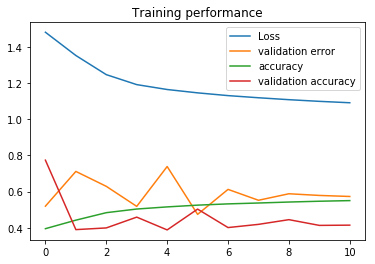

In [44]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='Loss')
plt.plot(history.epoch, history.history['val_loss'], label='validation error')
plt.plot(history.epoch, history.history['acc'], label='accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
plt.legend()